## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: in progress
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG19
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_folder = 'split/train'
test_folder = 'split/test'
val_folder = 'split/validation'

## VGG19: Feature extraction

In [3]:
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [4]:
vgg19_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Feature Extraction: Method 2

Here, another method is employed to perform feature extraction which will segue naturally into methods for fine tuning a pretrained network. This method of feature extraction is more costly than the previous methodology but has some added benefits in that it will allow us to also perform our usual data augmentation techniques.  

Here's an overview of the process:
* Add the pretrained model as the first layer
* Add some dense layers for a classifier on top
* Freeze the convolutional base
* Train the model

The new part of this process which you have yet to see is freezing layers. This means that all of the weights associated with that layer(s) will remain unchanged through the optimization process. Freezing the base is important as you wish to preserve the features encoded in this CNN base. Without this, the volatile gradients will quickly erase the useful features of the pretrained model. 

In [6]:
model = models.Sequential()
model.add(vgg19_base)
model.add(layers.Flatten())
model.add(layers.Dense(132, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 132)               1081476   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 133       
Total params: 21,105,993
Trainable params: 21,105,993
Non-trainable params: 0
_________________________________________________________________


## Freezing

Now that you've designed the model architecture, you'll freeze the base. With this, learning to check whether layers are frozen or not is a valuable skill.

In [8]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model.trainable_weights))

vgg19 True
flatten True
dense True
dense_1 True
36


Freezing a layer is very straightforward: set the `trainable` attribute to False.

In [9]:
vgg19_base.trainable = False

A quick sanity check is also prudent and verifies that the base model is indeed frozen:

In [10]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(model.trainable_weights))

vgg19 False
flatten True
dense True
dense_1 True
4


From there, training the model happens as usual.   

Define the training-validation-test sets (now with data augmentation; the advantage of this method of feature-extraction).

In [11]:
# Get all the data in the directory split/train (3410 images), and reshape them
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_folder, target_size=(150, 150), batch_size=1000)
                                                    #, 
                                                    #class_mode= 'binary') 

# Get all the data in the directory split/validation (420 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(150, 150), batch_size=400)
                                                                       #, 
                                                                       #class_mode='binary')

# Get all the data in the directory split/test (420 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(150, 150), batch_size=400)
                                                                        #,
                                                                        #class_mode='binary')

Found 4685 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


In [12]:
test_images, test_labels = next(test_generator)
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)

In [13]:
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(1000, 2)
(400, 2)
(400, 2)


In [14]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [15]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(1000, 1)
(400, 1)
(400, 1)


Compile the model as usual:

In [17]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

And fit the model:

In [18]:
# ⏰ This cell may take several minutes to run
start = datetime.datetime.now()
print('program starts, current time:')
print(start)
history = model.fit(train_images, train_y, epochs=40, batch_size=25, validation_data=(val_images, val_y))
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2020-11-16 08:01:24.143300
Epoch 1/40
40/40 [==============================] - 1213s 30s/step - loss: 0.5695 - accuracy: 0.7000 - val_loss: 0.5068 - val_accuracy: 0.7050
Epoch 2/40
40/40 [==============================] - 1307s 33s/step - loss: 0.4482 - accuracy: 0.7660 - val_loss: 0.3991 - val_accuracy: 0.8250
Epoch 3/40
40/40 [==============================] - 1319s 33s/step - loss: 0.3832 - accuracy: 0.8220 - val_loss: 0.3505 - val_accuracy: 0.8725
Epoch 4/40
40/40 [==============================] - 1322s 33s/step - loss: 0.3447 - accuracy: 0.8560 - val_loss: 0.3220 - val_accuracy: 0.8675
Epoch 5/40
40/40 [==============================] - 1316s 33s/step - loss: 0.3179 - accuracy: 0.8640 - val_loss: 0.3057 - val_accuracy: 0.8700
Epoch 6/40
40/40 [==============================] - 1294s 32s/step - loss: 0.2959 - accuracy: 0.8800 - val_loss: 0.3038 - val_accuracy: 0.8950
Epoch 7/40
40/40 [==============================] - 1290s 32s/step - loss: 0.2831 - a

In [19]:
results_train = model.evaluate(train_images, train_y)
results_train

32/32 [==============================] - 742s 23s/step - loss: 0.1322 - accuracy: 0.9620


[0.13219694793224335, 0.9620000123977661]

In [20]:
results_test = model.evaluate(test_images, test_y)
results_test

13/13 [==============================] - 360s 28s/step - loss: 0.1519 - accuracy: 0.9375


[0.15193124115467072, 0.9375]

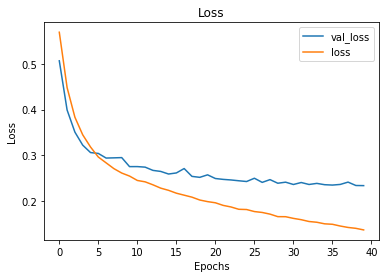

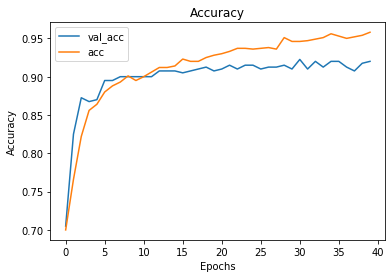

In [21]:
visualize_training_results(history)

## Saving Whole Base Freezed VGG19 Model

In [22]:
from datetime import date
model.save('vgg19_whole_base_frozen_chest_xray_ALL_data_'+str(date.today())+'_method2.h5')

In [23]:
preds_model = model.predict(test_images)

In [24]:
type(preds_model)

numpy.ndarray

In [25]:
preds_model.shape

(400, 1)

In [26]:
test_y.shape

(400, 1)

In [27]:
pred_model_class = model.predict_classes(test_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [28]:
pred_model_class.shape

(400, 1)

In [29]:
pred_model_binary_class = (model.predict(test_images) > 0.5).astype("int32")
pred_model_binary_class.shape

(400, 1)

In [30]:
accuracy_model = accuracy_score(test_y, preds_model.round())
accuracy_model

0.9375

In [31]:
precision_model = precision_score(test_y, preds_model.round())
precision_model

0.8739495798319328

In [32]:
recall_model = recall_score(test_y, preds_model.round())
recall_model

0.9122807017543859

In [33]:
f1_model = f1_score(test_y, preds_model.round())
f1_model

0.8927038626609443

In [34]:
auc_value_model = roc_auc_score(test_y, preds_model)
auc_value_model

0.983008219850325

In [35]:
# test set
true_classes_vgg19 = test_generator.classes
print(true_classes_vgg19)
class_labels_vgg19 = list(test_generator.class_indices.keys())
class_labels_vgg19

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [36]:
fpr_model, tpr_model, threshold_model = roc_curve(test_y, preds_model)

In [37]:
roc_auc_model = auc(fpr_model, tpr_model)

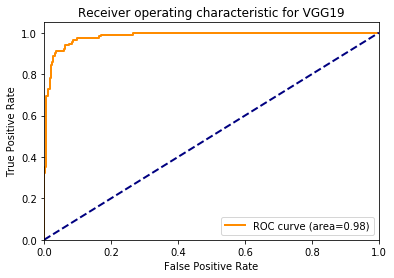

In [38]:
plt.figure()
lw=2
plt.plot(fpr_model, tpr_model, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_model)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for VGG19')
plt.legend(loc='lower right')
plt.show()

In [39]:
report_model = classification_report(test_y, preds_model.round())
print(report_model)

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       286
         1.0       0.87      0.91      0.89       114

    accuracy                           0.94       400
   macro avg       0.92      0.93      0.92       400
weighted avg       0.94      0.94      0.94       400



In [40]:
cnf_matrix_model = confusion_matrix(y_true=test_y, y_pred=preds_model.round())
np.set_printoptions(precision=2)
print(cnf_matrix_model)

[[271  15]
 [ 10 104]]


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
cm_plot_labels = ['NORMAL','PNEUMONIA']

Confusion matrix, without normalization
[[271  15]
 [ 10 104]]


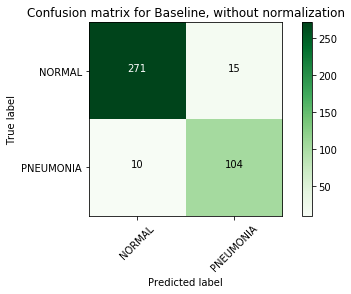

In [43]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model, classes=cm_plot_labels, title='Confusion matrix for Baseline, without normalization')
plt.show()

Normalized confusion matrix
[[0.95 0.05]
 [0.09 0.91]]


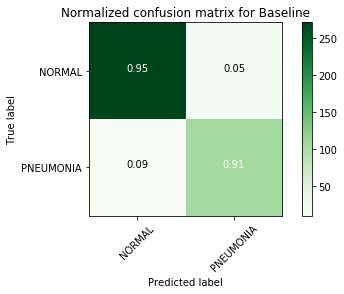

In [44]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

## Saving history in CSV

In [45]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'vgg19_whole_base_frozen_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

> Note that whenever training AND VALIDATION accuracy continue to drop, then the model is probably underfit and can benefit from additional epochs.

## Fine Tuning

Fine tuning starts with the same procedure as that for feature extraction. From there, we can further fine tune the weights of the most abstract layers of the convolutional base. 

When fine tuning these layers from the convolutional base, it is essential that we first freeze the entire convolutional base and train a classifier as we discussed with the feature engineering technique above. Without this, when gradient descent is initialized to optimize our loss function, we're apt to loose any significant patterns learned by the original classifier that we're adapting to the current situation. As a result, we must first tune the fully connected classifier that sits on top of the pretrained convolutional base. From there, the model should have a relatively strong accuracy and you can fine tune the weights of the last few layers of the convolutional base. Unfreezing initial layers of the convolutional base will typically not produce substantial gains as these early layers learn simple representations such as colors and edges which are useful in all forms of image recognition, regardless of application.   

With that, let's continue fine-tuning the model.

**Warning: Fine tuning can be a resource intensive procedure.** 

Recall that model's architecture: 

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 132)               1081476   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 133       
Total params: 21,105,993
Trainable params: 1,081,609
Non-trainable params: 20,024,384
_________________________________________________________________


And you can also further investigate the borrowed convolutional base:

In [47]:
vgg19_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Important Reminders on Fine Tuning: Feature Extraction Must Come First!

Up to now, the entire convolutional base has been frozen. Again, it cannot be stressed enough how important this is before fine tuning the weights of the later layers of this base. Without training a classifier on the frozen base first, there will be too much noise in the model and initial epochs will overwrite any useful representations encoded in the pretrained model. That said, now that `a classifier to the frozen base has been tuned, a few of the deeper layers from this base can be now unfrozen, and we can further fine tune them to our problem scenario`. In practice, this is apt to be particularly helpful where adapted models span new domain categories. For example, if the pretrained model is on cats and dogs and this is adapted to a problem specific to cats (a very relatively similar domain) there is apt to be little performance gain from fine tuning. On the other hand, `if the problem domain is substantially different, additional gains are more likely in adjusting these more abstract layers of the convolutional base`. With that, here's how to unfreeze and fine tune these later layers.

First, unfreeze the base.

In [48]:
vgg19_base.trainable = True

Then, we refreeze all layers up to a specific layer. Here we're unfreezing the final *block* of layers.  
(We will see diminishing returns if you continue to unfreeze additional layers.) 

In [49]:
vgg19_base.trainable = True
set_trainable = False
#layer_list = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
layer_list = ['block5_conv4', 'block5_pool']
for layer in vgg19_base.layers:
    if layer.name in layer_list :
        set_trainable = True
        layer.trainable = True
    else:
        layer.trainable = False

In [50]:
model2 = models.Sequential()
model2.add(vgg19_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [51]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                131088    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 20,155,489
Trainable params: 2,490,913
Non-trainable params: 17,664,576
_________________________________________________________________


In [52]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model2.layers:
    print(layer.name, layer.trainable)

print('-------------------------------')
for layer in vgg19_base.layers:
    print(layer.name, layer.trainable)    
    
print('-------------------------------')
# Similarly, we can check how many trainable weights are in the model
print(len(model2.trainable_weights))

vgg19 True
flatten_1 True
dense_2 True
dense_3 True
-------------------------------
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_conv4 True
block5_pool True
-------------------------------
6


Finally, we must recompile our model before fitting.

In [53]:
model2.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

Afterwards, we can then fit the model as usual.

In [54]:
# ⏰ This cell may take several minutes to run
start2 = datetime.datetime.now()
print('program starts, current time:')
print(start2)
#history3 = model2.fit_generator(train_generator, steps_per_epoch=27, epochs=10, validation_data=val_generator, validation_steps=10)
history2 = model2.fit(train_images, train_y, epochs=40, batch_size=25, validation_data=(val_images, val_y))
end2 = datetime.datetime.now()
print('program ends, current time:')
print(end2)
elapsed2 = end2 - start2
print('Training took a total of {}'.format(elapsed2))

program starts, current time:
2020-11-17 01:51:35.047095
Epoch 1/40
40/40 [==============================] - 1173s 29s/step - loss: 0.5162 - accuracy: 0.7370 - val_loss: 0.3839 - val_accuracy: 0.8600
Epoch 2/40
40/40 [==============================] - 1358s 34s/step - loss: 0.3792 - accuracy: 0.8300 - val_loss: 0.3136 - val_accuracy: 0.8900
Epoch 3/40
40/40 [==============================] - 1374s 34s/step - loss: 0.3084 - accuracy: 0.8760 - val_loss: 0.2944 - val_accuracy: 0.8925
Epoch 4/40
40/40 [==============================] - 1385s 35s/step - loss: 0.2670 - accuracy: 0.8920 - val_loss: 0.2679 - val_accuracy: 0.9075
Epoch 5/40
40/40 [==============================] - 1393s 35s/step - loss: 0.2399 - accuracy: 0.9060 - val_loss: 0.2679 - val_accuracy: 0.9050
Epoch 6/40
40/40 [==============================] - 1392s 35s/step - loss: 0.2174 - accuracy: 0.9140 - val_loss: 0.2579 - val_accuracy: 0.9125
Epoch 7/40
40/40 [==============================] - 1391s 35s/step - loss: 0.2009 - a

In [55]:
results2_train = model2.evaluate(train_images, train_y)
results2_train

32/32 [==============================] - 780s 24s/step - loss: 0.0060 - accuracy: 1.0000


[0.005969819147139788, 1.0]

In [56]:
results2_test = model2.evaluate(test_images, test_y)
results2_test

13/13 [==============================] - 353s 27s/step - loss: 0.1670 - accuracy: 0.9375


[0.16695906221866608, 0.9375]

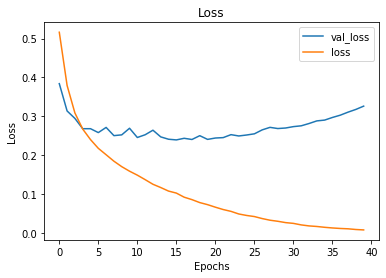

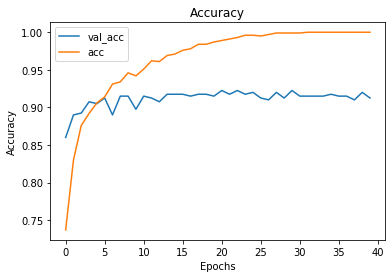

In [57]:
visualize_training_results(history2)

## Saving Fine-tuned (Top Abstract Layer Unfreezed) VGG19 Model

In [58]:
model2.save('vgg19_fine_tuned_chest_xray_ALL_data_'+str(date.today())+'.h5')

In [59]:
preds_model2 = model2.predict(test_images)

In [60]:
type(preds_model2)

numpy.ndarray

In [61]:
preds_model2.shape

(400, 1)

In [62]:
test_images.shape

(400, 150, 150, 3)

In [63]:
pred_model2_class = model2.predict_classes(test_images)

In [64]:
pred_model2_class.shape

(400, 1)

In [65]:
pred_model2_binary_class = (model2.predict(test_images) > 0.5).astype("int32")
pred_model2_binary_class.shape

(400, 1)

In [66]:
accuracy_model2 = accuracy_score(test_y, preds_model2.round())
accuracy_model2

0.9375

In [67]:
precision_model2 = precision_score(test_y, preds_model2.round())
precision_model2

0.8503937007874016

In [68]:
recall_model2 = recall_score(test_y, preds_model2.round())
recall_model2

0.9473684210526315

In [69]:
f1_model2 = f1_score(test_y, preds_model2.round())
f1_model2

0.896265560165975

In [70]:
auc_value_model2 = roc_auc_score(test_y, preds_model2)
auc_value_model2

0.9873635136793031

In [71]:
fpr_model2, tpr_model2, threshold_model2 = roc_curve(test_y, preds_model2)

In [72]:
roc_auc_model2 = auc(fpr_model2, tpr_model2)

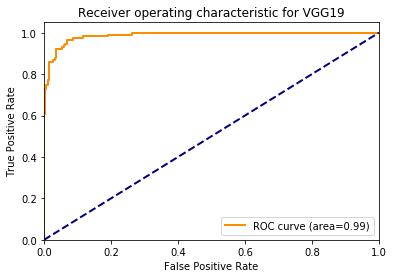

In [73]:
plt.figure()
lw=2
plt.plot(fpr_model2, tpr_model2, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_model2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for VGG19')
plt.legend(loc='lower right')
plt.show()

In [74]:
report_model2 = classification_report(test_y, preds_model2.round())
print(report_model2)

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       286
         1.0       0.85      0.95      0.90       114

    accuracy                           0.94       400
   macro avg       0.91      0.94      0.93       400
weighted avg       0.94      0.94      0.94       400



In [75]:
cnf_matrix_model2 = confusion_matrix(y_true=test_y, y_pred=preds_model2.round())
np.set_printoptions(precision=2)
print(cnf_matrix_model2)

[[267  19]
 [  6 108]]


Confusion matrix, without normalization
[[267  19]
 [  6 108]]


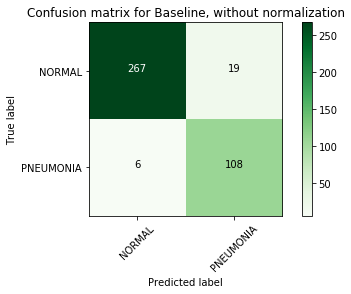

In [76]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model2, classes=cm_plot_labels, title='Confusion matrix for Baseline, without normalization')
plt.show()

Normalized confusion matrix
[[0.93 0.07]
 [0.05 0.95]]


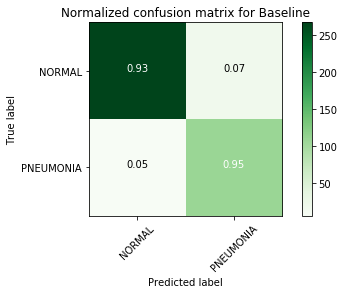

In [77]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model2, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

## Saving history in CSV

In [78]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history2.history) 
# or save to csv: 
hist_csv_file = 'vgg19_fine_tuned_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Comparing Methods

* accuracy history plot for freezing and unfreezing the last few abstract layers of VGG19 convolutional base 

In [ ]:
# frozen model details
vgg19_dict = history2.history
vgg19_acc_values = vgg19_dict['accuracy'] 
vgg19_val_acc_values = vgg19_dict['val_accuracy']

# unfrozen model
vgg19_tuned_dict = history3.history
vgg19_tuned_acc = vgg19_tuned_dict['accuracy'] 
vgg19_tuned_val_acc = vgg19_tuned_dict['val_accuracy']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(vgg19_tuned_acc) + 1)
ax.plot(epochs, vgg19_acc_values[:10], label='Training accuracy (frozen VGG19 base)')
ax.plot(epochs, vgg19_val_acc_values[:10], label='Validation accuracy (frozen VGG19 base)')
ax.plot(epochs, vgg19_tuned_acc, label='Training accuracy (unfrozen VGG19 base)')
ax.plot(epochs, vgg19_tuned_val_acc, label='Validation accuracy (unfrozen VGG19 base)')
ax.set_title('Training & validation accuracy frozen VGG19 vs unfrozen VGG19')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

* loss history plot for freezing and unfreezing the last few abstract layers of VGG19 convolutional base

In [ ]:
# CNN model details
vgg19_dict = history2.history
vgg19_loss_values = vgg19_dict['loss'] 
vgg19_val_loss_values = vgg19_dict['val_loss']

# Baseline model
vgg19_tuned_dict = history3.history
vgg19_tuned_loss = vgg19_tuned_dict['loss'] 
vgg19_tuned_val_loss = vgg19_tuned_dict['val_loss']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(vgg19_tuned_loss) + 1)
ax.plot(epochs, vgg19_loss_values[:10], label='Training loss (frozen VGG19 base)')
ax.plot(epochs, vgg19_val_loss_values[:10], label='Validation loss (frozen VGG19 base)')
ax.plot(epochs, vgg19_tuned_loss, label='Training loss (unfrozen VGG19 base)')
ax.plot(epochs, vgg19_tuned_val_loss, label='Validation loss (unfrozen VGG19 base)')
ax.set_title('Training & validation frozen VGG19 vs unfrozen VGG19')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();